In [1]:
from Alice_Macros import *
from statsmodels.stats.multitest import multipletests
import matplotlib.pylab as plt
from TreeOperations import PhyFisher
from TreeOperations import GetPhyloContingency
from rpy2 import robjects
import numpy as np
from numpy.random import binomial
from scipy import sparse as sp
from scipy.stats import binom, poisson, rv_discrete, pearsonr, spearmanr
from scipy.stats.distributions import hypergeom, norm
import os
import bisect
import tqdm
import pickle 
import sys
import ete3
import tqdm
import itertools
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
from statsmodels.stats.weightstats import DescrStatsW
def w_pearson(dat, w):
    d = DescrStatsW(dat, weights=w)
    return d.corrcoef[0][1]

In [292]:
def fig0(mut_list, pop, ntimes, pval_list, outpath, weight=False, euc=False, na_all=False):
    # where we plot the log pval pearsom correlations
    dat_points = []
    for mut in mut_list:
        for i in range(ntimes):
            table_path = os.path.join(outpath, f'mut_{mut}_pop_{pop}_{i}')
            table = pd.read_pickle(table_path)
            table['bayes_score_corr'] = BF_to_pval(table['bayes_score'].values)
            table = table[pval_list]
            if na_all: table = table.dropna()
            for col,val in zip(table, table[table.gt(0)].min(0)):
                table[col] = table[col].replace({0:val})
            table = np.log10(table)
            
            for pval in pval_list[1:]:
                usetable = table[[pval_list[0], pval]].dropna()
                dist = np.abs(usetable[pval] - usetable[pval_list[0]]) ** (2 if euc else 1)
                dist = sum(dist * ((1/(10**usetable[pval_list[0]])) if weight else 1))
                dist = (np.sqrt(dist) if euc else dist) / len(usetable)
                dat_points.append([mut, pval, dist])        
    return pd.DataFrame(dat_points, columns=['mut', 'pval type', 'dist'])

In [345]:
def fig1(mut_list, pop, ntimes, pval_list, outpath, spear=False, weight=False, na_all=False):
    # where we plot the log pval pearsom correlations
    dat_points = []
    for mut in mut_list:
        for i in range(ntimes):
            table_path = os.path.join(outpath, f'mut_{mut}_pop_{pop}_{i}')
            table = pd.read_pickle(table_path)
            table['bayes_score_corr'] = BF_to_pval(table['bayes_score'].values)
            table = table[pval_list]
            if na_all: table = table.dropna()
            for col,val in zip(table, table[table.gt(0)].min(0)):
                table[col] = table[col].replace({0:val})
            table = np.log10(table)
            
            for pval in pval_list[1:]:
                usetable = table[[pval_list[0], pval]].dropna()
                if spear:
                    corrs = spearmanr(usetable[pval], usetable[pval_list[0]])[0]
                elif weight:
                    corrs = w_pearson(usetable[[pval, pval_list[0]]], 1/(10**usetable[pval_list[0]]))
                else:
                    corrs = pearsonr(usetable[pval], usetable[pval_list[0]])[0]
                dat_points.append([mut, pval, corrs])        
    return pd.DataFrame(dat_points, columns=['mut', 'pval type', 'corr'])

In [5]:
def fig2(mut, pop_list, ntimes, pval_list, outpath, spear=False, weight=False):
    # where we plot constant mutation number and changng trees
    dat_points = []
    for pop in pop_list:
        for i in range(ntimes):
            table_path = os.path.join(outpath, f'mut_{mut}_pop_{pop}_{i}')
            table = pd.read_pickle(table_path)[pval_list]
            for col,val in zip(table, table[table.gt(0)].min(0)):
                table[col] = table[col].replace({0:val})
            table = np.log10(table)
            
            for pval in pval_list[1:]:
                if spear:
                    corrs = spearmanr(table[pval], table[pval_list[0]])[0]
                elif weight:
                    corrs = w_pearson(table[[pval, pval_list[0]]], 1/(10**table[pval_list[0]]))
                else:
                    corrs = pearsonr(table[pval], table[pval_list[0]])[0]
                dat_points.append(['const_mut', pop, pval, corrs])
    
    # and constant mutation rates and changing trees
    for pop in pop_list:
        for i in range(ntimes):
            table_path = os.path.join(outpath, f'const_rate_pop_{pop}_{i}')
            table = pd.read_pickle(table_path)[pval_list]
            for col,val in zip(table, table[table.gt(0)].min(0)):
                table[col] = table[col].replace({0:val})
            table = np.log10(table)
            
            for pval in pval_list[1:]:
                if spear:
                    corrs = spearmanr(table[pval], table[pval_list[0]])[0]
                elif weight:
                    corrs = w_pearson(table[[pval, pval_list[0]]], 1/(10**table[pval_list[0]]))
                else:
                    corrs = pearsonr(table[pval], table[pval_list[0]])[0]
                dat_points.append(['const_rate', pop, pval, corrs])
    # and another one for the already calculated, but not saved in the same format
    return pd.DataFrame(dat_points, columns=['rate_type', 'pop', 'pval type', 'corr'])

In [6]:
def fig3(mut_list, pop, ntimes, pval_list, outpath, spear=False, weight=False, dist=False, euc=False):
    # where we plot for 2 increcingly differing mutation rates, with the lower fixed at 10
    dat_points = []
    for mut in mut_list:
        for i in range(ntimes):
            if mut == 10:
                table_path = os.path.join(outpath, f'mut_10_pop_{pop}_{i}')
            else:
                table_path = os.path.join(outpath, f'mutmix_10_{mut}_pop_{pop}_{i}')
            table = pd.read_pickle(table_path)[pval_list]
            for col,val in zip(table, table[table.gt(0)].min(0)):
                table[col] = table[col].replace({0:val})
            table = np.log10(table)
            
            for pval in pval_list[1:]:
                if dist:
                    corrs = np.abs(table[pval] - table[pval_list[0]]) ** (2 if euc else 1)
                    corrs = sum(corrs * ((1/(10**table[pval_list[0]])) if weight else 1))
                    corrs = (np.sqrt(corrs) if euc else corrs) / len(table)
                    dat_points.append([mut, pval, corrs])
                else:
                    if spear:
                        corrs = spearmanr(table[pval], table[pval_list[0]])[0]
                    elif weight:
                        corrs = w_pearson(table[[pval, pval_list[0]]], 1/(10**table[pval_list[0]]))
                    else:
                        corrs = pearsonr(table[pval], table[pval_list[0]])[0]
                dat_points.append([mut, pval, corrs])        
    return pd.DataFrame(dat_points, columns=['mut', 'pval type', 'dist' if dist else 'corr'])

In [7]:
def fig4(mut_list, pop, ntimes, pval_list, outpath, spear=False, weight=False, dist=False, euc=False):
    # where we compare modeling random branch lengths
    dat_points = []
    for mut in mut_list:
        for i in range(ntimes):
            table_path = os.path.join(outpath, f'prop_mut_{mut}_pop_{pop}_{i}')
            table = pd.read_pickle(table_path)[pval_list]
            for col,val in zip(table, table[table.gt(0)].min(0)):
                table[col] = table[col].replace({0:val})
            table = np.log10(table)
            
            for pval in pval_list[1:]:
                if dist:
                    corrs = np.abs(table[pval] - table[pval_list[0]]) ** (2 if euc else 1)
                    corrs = sum(corrs * ((1/(10**table[pval_list[0]])) if weight else 1))
                    corrs = (np.sqrt(corrs) if euc else corrs) / len(table)
                    dat_points.append([mut, pval, corrs])
                else:
                    if spear:
                        corrs = spearmanr(table[pval], table[pval_list[0]])[0]
                    elif weight:
                        corrs = w_pearson(table[[pval, pval_list[0]]], 1/(10**table[pval_list[0]]))
                    else:
                        corrs = pearsonr(table[pval], table[pval_list[0]])[0]
                dat_points.append([mut, pval, corrs])        
    return pd.DataFrame(dat_points, columns=['mut', 'pval type', 'dist' if dist else 'corr'])

In [370]:
outpath = '/home/kishonylab/Gal/Workdir/ALISE/figs_data'

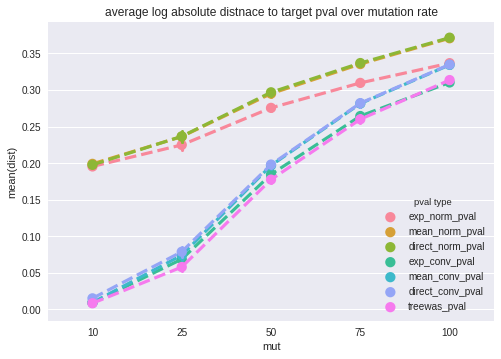

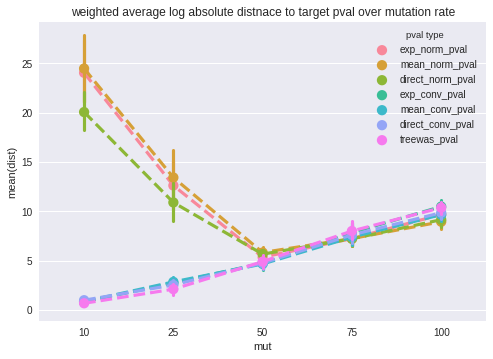

In [8]:
# old ver
plt.close('all')
outpath = '/home/kishonylab/Gal/Workdir/ALISE/figs_data'
n_mutations_list = [10, 25, 50, 75, 100]
pop = 500
ntimes = 10
pval_list = ['pval', 
             'exp_norm_pval', 'mean_norm_pval', 'direct_norm_pval',
             'exp_conv_pval', 'mean_conv_pval', 'direct_conv_pval',
             'treewas_pval']
dat = fig0(n_mutations_list, pop, ntimes, pval_list, outpath)
sns.pointplot(x='mut', y='dist', hue='pval type', data=dat, linestyles='--')
plt.title('average log absolute distnace to target pval over mutation rate')
plt.figure()
dat = fig0(n_mutations_list, pop, ntimes, pval_list, outpath, weight=True)
sns.pointplot(x='mut', y='dist', hue='pval type', data=dat, linestyles='--', weight=True)
plt.title('weighted average log absolute distnace to target pval over mutation rate')
plt.show()

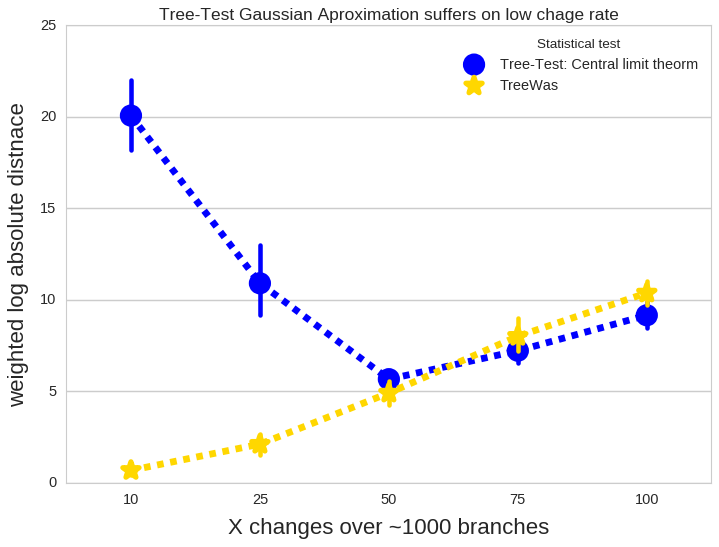

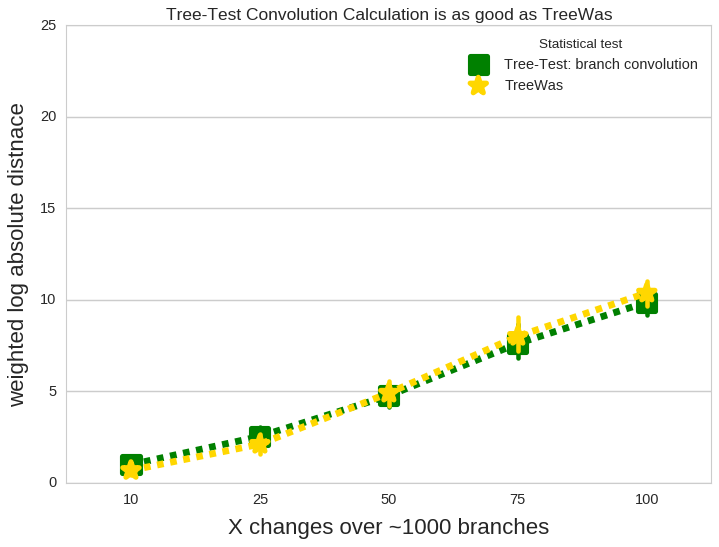

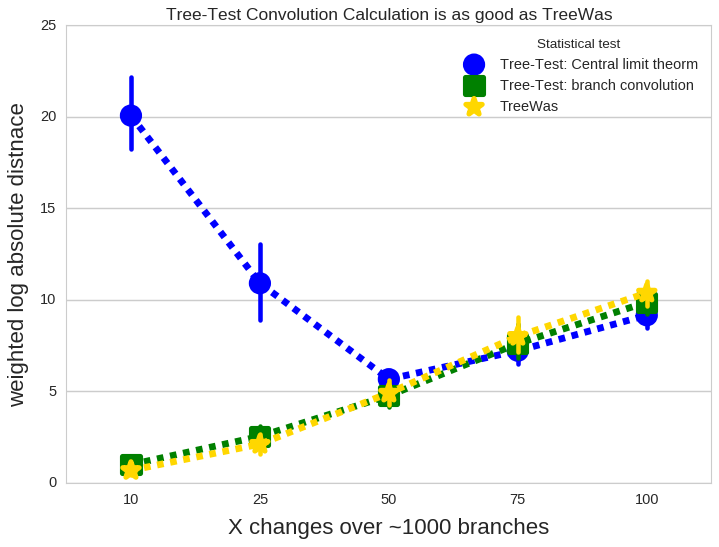

In [129]:
# new ver
# sns.set_style('white')
plt.style.use('seaborn-talk')
plt.close('all')
outpath = '/home/kishonylab/Gal/Workdir/ALISE/figs_data'
n_mutations_list = [10, 25, 50, 75, 100]
pop = 500
ntimes = 10
pval_list = ['pval', 
             'direct_norm_pval',
             'treewas_pval']
dat = fig0(n_mutations_list, pop, ntimes, pval_list, outpath, weight=True)
dat.columns = ['Change rate: Number of changes over 1000 branches',
               'Statistical test',
               'weighted log absolute distnace']
dat[dat.columns[1]] = dat[dat.columns[1]].replace(
    {'direct_norm_pval': 'Tree-Test: Central limit theorm',
     'treewas_pval':'TreeWas'})
pntplt = sns.pointplot(x=dat.columns[0], y=dat.columns[-1], hue=dat.columns[1], data=dat, linestyles='--', 
              weight=True, markers=["o", "*"], scale = 1.5, palette=['b', 'gold'])
pntplt.set_ylabel('weighted log absolute distnace', rotation=90, fontsize=20, labelpad=10)
pntplt.set_xlabel('X changes over ~1000 branches', rotation=0, fontsize=20, labelpad=10)
plt.title('Tree-Test Gaussian Aproximation suffers on low chage rate')
plt.ylim(0,25)
plt.show()

plt.figure()
pval_list = ['pval', 
             'direct_conv_pval',
             'treewas_pval']
dat = fig0(n_mutations_list, pop, ntimes, pval_list, outpath, weight=True)
dat.columns = ['Change rate: Number of changes over 1000 branches',
               'Statistical test',
               'weighted log absolute distnace']
dat[dat.columns[1]] = dat[dat.columns[1]].replace(
    {'treewas_pval':'TreeWas',
     'direct_conv_pval': 'Tree-Test: branch convolution'})
pntplt = sns.pointplot(x=dat.columns[0], y=dat.columns[-1], hue=dat.columns[1], data=dat, linestyles='--', 
              weight=True, markers=["s", "*"], scale = 1.5, palette=['g', 'gold'])
pntplt.set_ylabel('weighted log absolute distnace', rotation=90, fontsize=20, labelpad=10)
pntplt.set_xlabel('X changes over ~1000 branches', rotation=0, fontsize=20, labelpad=10)
plt.title('Tree-Test Convolution Calculation is as good as TreeWas')
plt.ylim(0,25)
plt.show()


plt.figure()
pval_list = ['pval',
             'direct_norm_pval',
             'direct_conv_pval',
             'treewas_pval']
dat = fig0(n_mutations_list, pop, ntimes, pval_list, outpath, weight=True)
dat.columns = ['Change rate: Number of changes over 1000 branches',
               'Statistical test',
               'weighted log absolute distnace']
dat[dat.columns[1]] = dat[dat.columns[1]].replace(
    {'treewas_pval':'TreeWas',
     'direct_norm_pval': 'Tree-Test: Central limit theorm',
     'direct_conv_pval': 'Tree-Test: branch convolution'})
pntplt = sns.pointplot(x=dat.columns[0], y=dat.columns[-1], hue=dat.columns[1], data=dat, linestyles='--', 
              weight=True, markers=["o", "s", "*"], scale = 1.5, palette=['b', 'g', 'gold'])
pntplt.set_ylabel('weighted log absolute distnace', rotation=90, fontsize=20, labelpad=10)
pntplt.set_xlabel('X changes over ~1000 branches', rotation=0, fontsize=20, labelpad=10)
plt.title('Tree-Test Convolution Calculation is as good as TreeWas')
plt.ylim(0,25)
plt.show()

In [ ]:
plt.figure()
pval_list = ['pval', 
             'direct_conv_pval',
             'treewas_pval']
dat = fig0(n_mutations_list, pop, ntimes, pval_list, outpath, weight=True, corr)
dat.columns = ['Mutation rate: Number of mutations over 1000 branches',
               'Statistical test',
               'weighted log absolute distnace']
dat[dat.columns[1]] = dat[dat.columns[1]].replace(
    {'treewas_pval':'TreeWas',
     'direct_conv_pval': 'Tree-Test: branch convolution'})
sns.pointplot(x=dat.columns[0], y=dat.columns[-1], hue=dat.columns[1], data=dat, linestyles='--', weight=True)
plt.ylim(0,25)
plt.title('weighted log absolute distnace to target pval over Mutation rate')
plt.show()

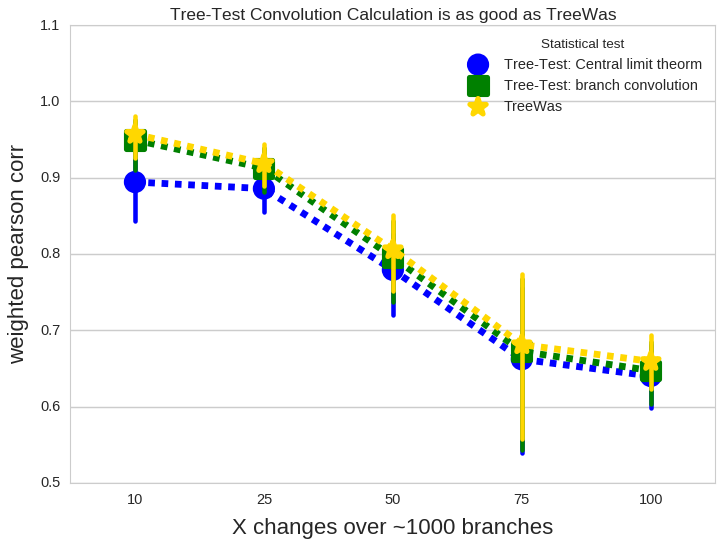

In [139]:
plt.figure()
pval_list = ['pval',
             'direct_norm_pval',
             'direct_conv_pval',
             'treewas_pval']
dat = fig1(n_mutations_list, pop, ntimes, pval_list, outpath, weight=True)
dat.columns = ['Change rate: Number of changes over 1000 branches',
               'Statistical test',
               'weighted pearson corr']
dat[dat.columns[1]] = dat[dat.columns[1]].replace(
    {'treewas_pval':'TreeWas',
     'direct_norm_pval': 'Tree-Test: Central limit theorm',
     'direct_conv_pval': 'Tree-Test: branch convolution'})
pntplt = sns.pointplot(x=dat.columns[0], y=dat.columns[-1], hue=dat.columns[1], data=dat, linestyles='--', 
              weight=True, markers=["o", "s", "*"], scale = 1.5, palette=['b', 'g', 'gold'])
pntplt.set_ylabel('weighted pearson corr', rotation=90, fontsize=20, labelpad=10)
pntplt.set_xlabel('X changes over ~1000 branches', rotation=0, fontsize=20, labelpad=10)
plt.title('Tree-Test Convolution Calculation is as good as TreeWas')
plt.show()

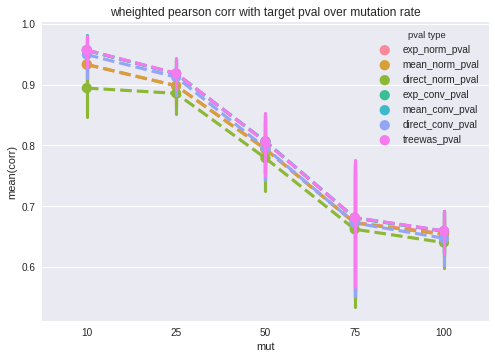

In [9]:
plt.close('all')
outpath = '/home/kishonylab/Gal/Workdir/ALISE/figs_data'
n_mutations_list = [10, 25, 50, 75, 100]
pop = 500
ntimes = 10
pval_list = ['pval', 
             'exp_norm_pval', 'mean_norm_pval', 'direct_norm_pval',
             'exp_conv_pval', 'mean_conv_pval', 'direct_conv_pval',
             'treewas_pval']
dat = fig1(n_mutations_list, pop, ntimes, pval_list, outpath, spear=False, weight=True)
sns.pointplot(x='mut', y='corr', hue='pval type', data=dat, linestyles='--')
plt.title('wheighted pearson corr with target pval over mutation rate')
plt.show()

In [84]:
# pearson correlation
plt.style.use('seaborn-whitegrid')
plt.close('all')
outpath = '/home/kishonylab/Gal/Workdir/ALISE/figs_data'
n_mutations_list = [10, 25, 50, 75, 100]
pop = 500
ntimes = 10
pval_list = ['pval', 
             'direct_norm_pval',
             'direct_conv_pval',
             'treewas_pval']
dat = fig1(n_mutations_list, pop, ntimes, pval_list, outpath, spear=False, weight=True)
dat.columns = ['Change rate: Number of changes over 1000 branches',
               'Statistical test',
               'Weighted (log pvalue) pearson correlation']
dat[dat.columns[1]] = dat[dat.columns[1]].replace(
    {'treewas_pval':'TreeWas',
     'direct_conv_pval': 'Tree-Test: branch convolution',
     'direct_norm_pval': 'Tree-Test: Central limit theorm'})
sns.pointplot(x=dat.columns[0], y=dat.columns[-1], hue=dat.columns[1], data=dat, linestyles='--', 
              weight=True, markers=["o", "s", "*"], scale = 1.5)
plt.title('Wheighted pearson over change rate')
plt.show()

TypeError: fig1() got an unexpected keyword argument 'dist'

In [147]:
dat.loc[0]

rate_type                      const_mut
pop                                  100
pval type               direct_conv_pval
corr                           0.0424814
group        const_mut: direct_conv_pval
Name: 0, dtype: object

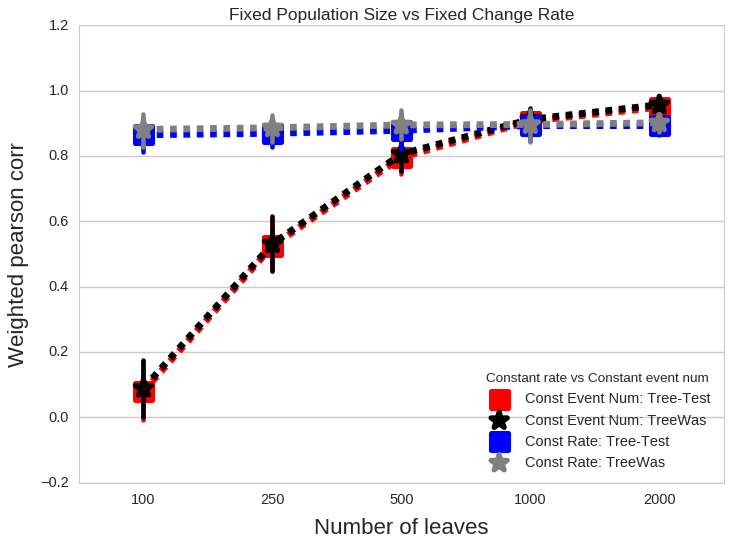

In [376]:
plt.close('all')
plt.figure()
pval_list = ['pval',
             'direct_conv_pval',
             'treewas_pval']
pop_list = [100, 250, 500, 1000, 2000]
mut = 50
ntimes = 10
dat = fig2(mut, pop_list, ntimes, pval_list, outpath, spear=False, weight=True)
dat['group'] = dat['rate_type'].str.cat(': '+dat['pval type'])
dat.columns = ['rae_type',
               'Population - number of leaves',
               'Statistical test',
               'Weighted pearson corr',
               'Constant rate vs Constant event num']
               
dat[dat.columns[2]] = dat[dat.columns[2]].replace(
    {'treewas_pval':'TreeWas',
     'direct_norm_pval': 'Tree-Test: Central limit theorm',
     'direct_conv_pval': 'Tree-Test: branch convolution'})

dat = dat.replace({'const_mut: direct_conv_pval': 'Const Event Num: Tree-Test',
             'const_mut: treewas_pval': 'Const Event Num: TreeWas',
             'const_rate: direct_conv_pval': 'Const Rate: Tree-Test',
             'const_rate: treewas_pval': 'Const Rate: TreeWas'})

pntplt = sns.pointplot(x=dat.columns[1], y=dat.columns[-2], hue=dat.columns[-1], data=dat, linestyles='--', 
              weight=True, markers=["s", "*", "s", "*"], scale = 1.5, palette=['r', 'black', 'b', 'grey'])
pntplt.set_ylabel('Weighted pearson corr', rotation=90, fontsize=20, labelpad=10)
pntplt.set_xlabel('Number of leaves', rotation=0, fontsize=20, labelpad=10)
plt.title('Fixed Population Size vs Fixed Change Rate')
plt.show()

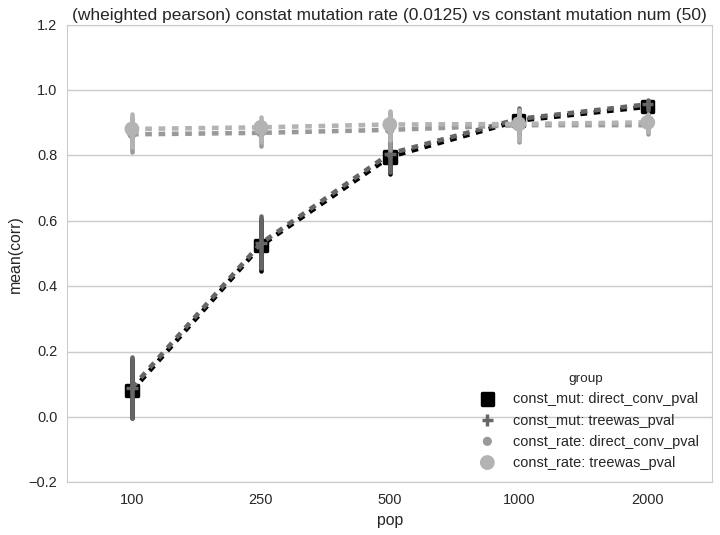

In [145]:
plt.close('all')
plt.figure()
plt.style.use('seaborn-talk')
outpath = '/home/kishonylab/Gal/Workdir/ALISE/figs_data'
pop_list = [100, 250, 500, 1000, 2000]
mut = 50
ntimes = 10
pval_list = ['pval', 
             #'exp_norm_pval', 'mean_norm_pval', 'direct_norm_pval', 'exp_conv_pval', 'mean_conv_pval', 
             'direct_conv_pval',
             'treewas_pval']
dat = fig2(mut, pop_list, ntimes, pval_list, outpath, spear=False, weight=True)
dat['group'] = dat['rate_type'].str.cat(': '+dat['pval type'])
to_plot = dat[dat['rate_type'] == 'const_mut']
marker = [',', '+', '.', 'o']
sns.pointplot(x='pop', y='corr', hue='group', data=dat, linestyles='--', markers=marker*2, alpha=.5)
plt.title('(wheighted pearson) constat mutation rate (0.0125) vs constant mutation num (50)')
plt.show()

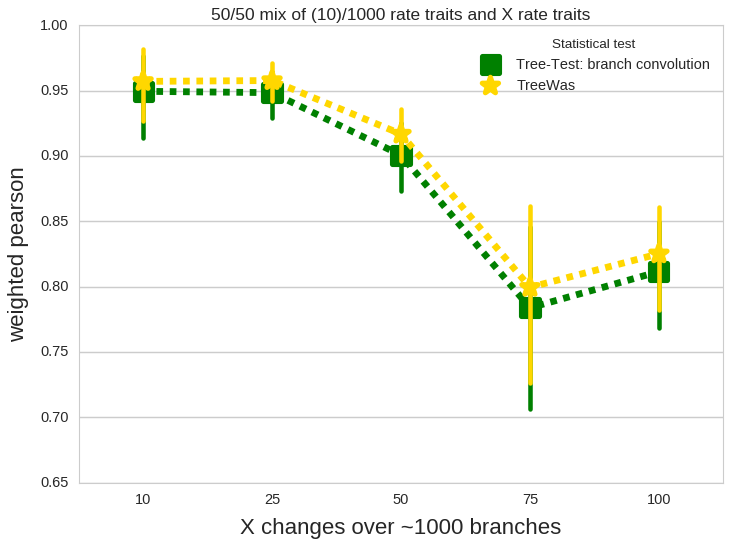

In [164]:
plt.close('all')
plt.style.use('seaborn-talk')
outpath = '/home/kishonylab/Gal/Workdir/ALISE/figs_data'
n_mutations_list = [10, 25, 50, 75, 100]
pop = 500
ntimes = 10
pval_list = ['pval', 
             'direct_conv_pval',
             'treewas_pval']
dist = False
dat = fig3(n_mutations_list, pop, ntimes, pval_list, outpath, spear=False, weight=True, dist=dist)
dat.columns = ['Change rate: Number of changes over 1000 branches',
               'Statistical test',
               'weighted log absolute distnace' if dist else 'weighted pearson']
dat[dat.columns[1]] = dat[dat.columns[1]].replace(
    {'treewas_pval':'TreeWas',
     'direct_conv_pval': 'Tree-Test: branch convolution'})
pntplt = sns.pointplot(x=dat.columns[0], y=dat.columns[-1], hue=dat.columns[1], data=dat, linestyles='--', 
              weight=True, markers=["s", "*"], scale = 1.5, palette=['g', 'gold'])

pntplt.set_ylabel('weighted log absolute distnace'  if dist else 'weighted pearson', rotation=90, fontsize=20, labelpad=10)
pntplt.set_xlabel('X changes over ~1000 branches', rotation=0, fontsize=20, labelpad=10)
plt.title('50/50 mix of (10)/1000 rate traits and X rate traits')

plt.show()

In [ ]:
# new fig
plt.close('all')
outpath = '/home/kishonylab/Gal/Workdir/ALISE/figs_data'
n_mutations_list = [10, 25, 50, 75, 100]
pop = 500
ntimes = 10
pval_list = ['pval', 
             'mean_conv_pval', 'direct_conv_pval',
             'treewas_pval']
dat = fig3(n_mutations_list, pop, ntimes, pval_list, outpath, spear=False, weight=True, dist=True)
sns.pointplot(x='mut', y='dist', hue='pval type', data=dat, linestyles='--')
plt.title('weighted distance with target pval over a 50/50 mix of (10)/1000 mutation rate and another mutation rate')
plt.show()

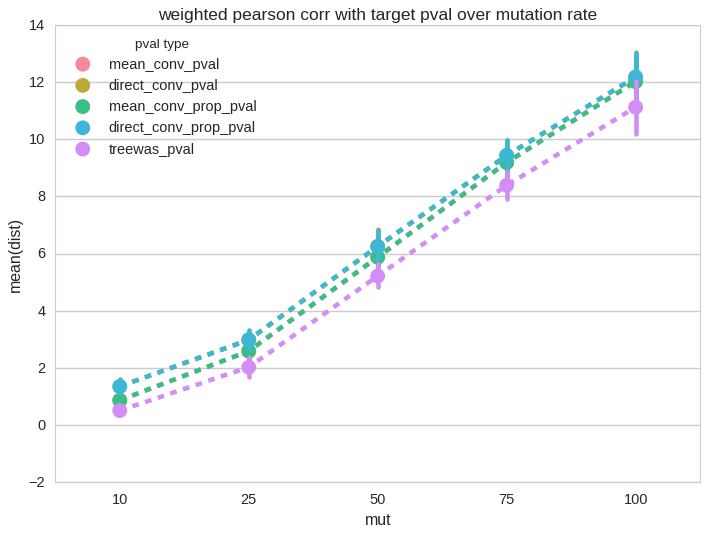

In [131]:
plt.close('all')
outpath = '/home/kishonylab/Gal/Workdir/ALISE/figs_data'
n_mutations_list = [10, 25, 50, 75, 100]
pop = 500
ntimes = 10
pval_list = ['pval', 
             'mean_conv_pval', 'direct_conv_pval',
             'mean_conv_prop_pval', 'direct_conv_prop_pval',
             'treewas_pval']
dat = fig4(n_mutations_list, pop, ntimes, pval_list, outpath, spear=False, weight=True, dist=True)
sns.pointplot(x='mut', y='dist', hue='pval type', data=dat, linestyles='--')
plt.title('weighted pearson corr with target pval over mutation rate')
plt.show()

# Cor-Mut score

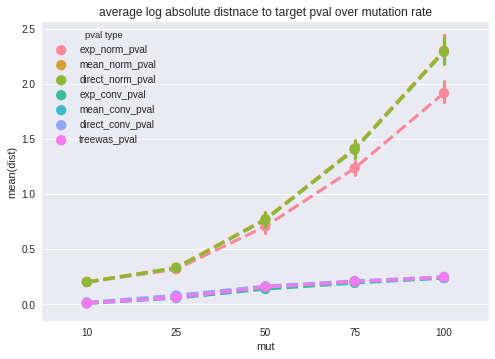

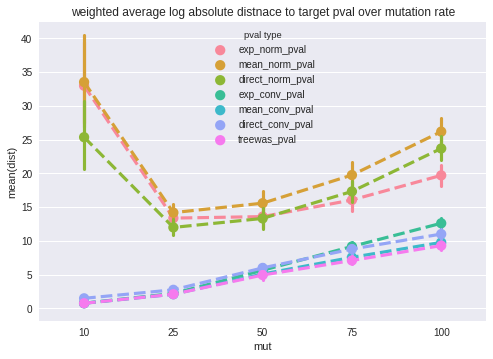

In [264]:
plt.close('all')
outpath = '/home/kishonylab/Gal/Workdir/ALISE/figs_data_coevent'
n_mutations_list = [10, 25, 50, 75, 100]
pop = 500
ntimes = 10
pval_list = ['pval', 
             'exp_norm_pval', 'mean_norm_pval', 'direct_norm_pval',
             'exp_conv_pval', 'mean_conv_pval', 'direct_conv_pval',
             'treewas_pval']
dat = fig0(n_mutations_list, pop, ntimes, pval_list, outpath)
sns.pointplot(x='mut', y='dist', hue='pval type', data=dat, linestyles='--')
plt.title('average log absolute distnace to target pval over mutation rate')
plt.figure()
dat = fig0(n_mutations_list, pop, ntimes, pval_list, outpath, weight=True)
sns.pointplot(x='mut', y='dist', hue='pval type', data=dat, linestyles='--', weight=True)
plt.title('weighted average log absolute distnace to target pval over mutation rate')
plt.show()

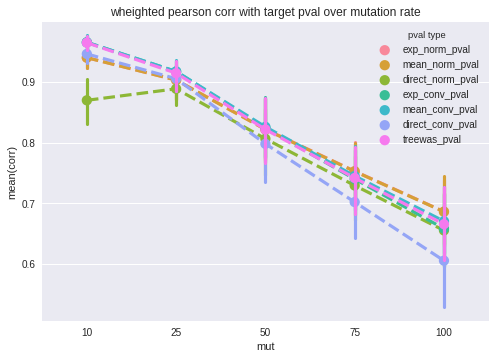

In [269]:
plt.close('all')
outpath = '/home/kishonylab/Gal/Workdir/ALISE/figs_data_coevent'
n_mutations_list = [10, 25, 50, 75, 100]
pop = 500
ntimes = 10
pval_list = ['pval', 
             'exp_norm_pval', 'mean_norm_pval', 'direct_norm_pval',
             'exp_conv_pval', 'mean_conv_pval', 'direct_conv_pval',
             'treewas_pval']
dat = fig1(n_mutations_list, pop, ntimes, pval_list, outpath, spear=False, weight=True)
sns.pointplot(x='mut', y='corr', hue='pval type', data=dat, linestyles='--')
plt.title('wheighted pearson corr with target pval over mutation rate')
plt.show()

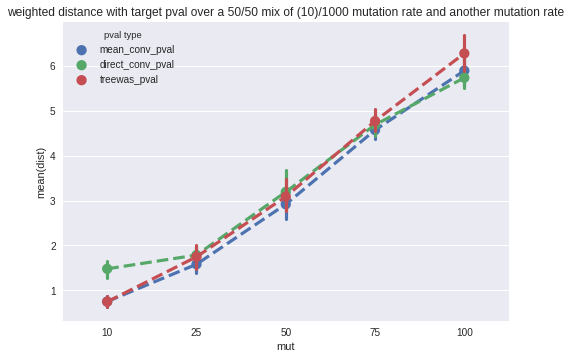

In [285]:
plt.close('all')
outpath = '/home/kishonylab/Gal/Workdir/ALISE/figs_data_coevent'
n_mutations_list = [10, 25, 50, 75, 100]
pop = 500
ntimes = 10
pval_list = ['pval', 
             'mean_conv_pval', 'direct_conv_pval',
             'treewas_pval']
dat = fig3(n_mutations_list, pop, ntimes, pval_list, outpath, spear=False, weight=True, dist=True)
sns.pointplot(x='mut', y='dist', hue='pval type', data=dat, linestyles='--')
plt.title('weighted distance with target pval over a 50/50 mix of (10)/1000 mutation rate and another mutation rate')
plt.show()

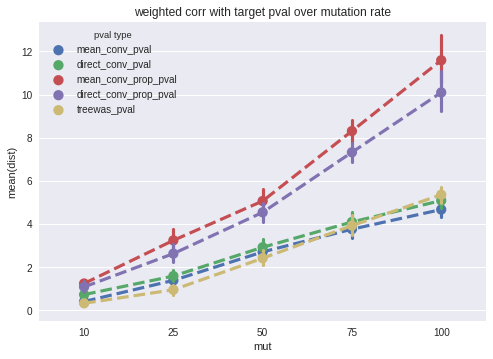

In [19]:
plt.close('all')
outpath = '/home/kishonylab/Gal/Workdir/ALISE/figs_data_coevent'
n_mutations_list = [10, 25, 50, 75, 100]
pop = 500
ntimes = 10
pval_list = ['pval', 
             'mean_conv_pval', 'direct_conv_pval',
             'mean_conv_prop_pval', 'direct_conv_prop_pval',
             'treewas_pval']
dat = fig4(n_mutations_list, pop, ntimes, pval_list, outpath, spear=False, weight=True, dist=True)
sns.pointplot(x='mut', y='dist', hue='pval type', data=dat, linestyles='--')
plt.title('weighted corr with target pval over mutation rate')
plt.show()

# V2 time

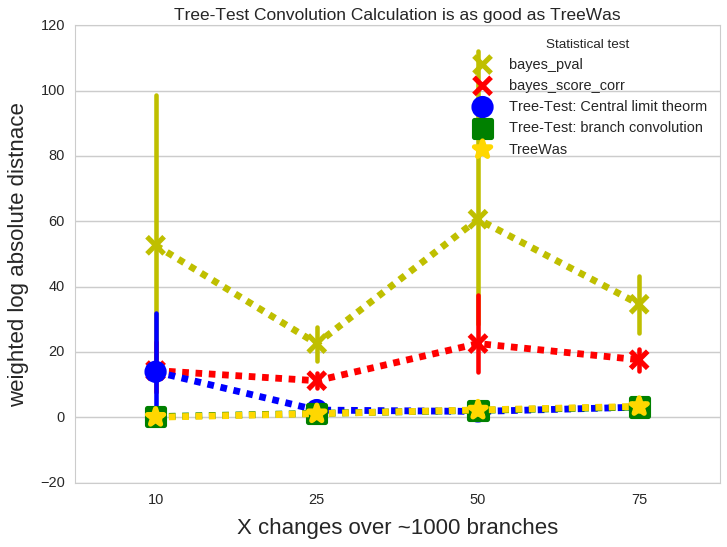

In [323]:
# new ver
# sns.set_style('white')
plt.style.use('seaborn-talk')
plt.close('all')
outpath = '/home/kishonylab/Gal/Workdir/ALISE/figs_data_v2'
n_mutations_list = [10, 25, 50, 75]
pop = 500
ntimes = 8
pval_list = ['pval', 
             'direct_norm_pval',
             'treewas_pval']

plt.figure()
pval_list = ['pval',
             'bayes_pval',
             'bayes_score_corr',
             'direct_norm_pval',
             'direct_conv_pval',
             'treewas_pval']
dat = fig0(n_mutations_list, pop, ntimes, pval_list, outpath, weight=True, na_all=True)
dat.columns = ['Change rate: Number of changes over 1000 branches',
               'Statistical test',
               'weighted log absolute distnace']
dat[dat.columns[1]] = dat[dat.columns[1]].replace(
    {'treewas_pval':'TreeWas',
     'direct_norm_pval': 'Tree-Test: Central limit theorm',
     'direct_conv_pval': 'Tree-Test: branch convolution'})
pntplt = sns.pointplot(x=dat.columns[0], y=dat.columns[-1], hue=dat.columns[1], data=dat, linestyles='--', 
              weight=True, markers=['x', 'x', "o", "s", "*"], scale = 1.5, palette=['y', 'r','b', 'g', 'gold'])
pntplt.set_ylabel('weighted log absolute distnace', rotation=90, fontsize=20, labelpad=10)
pntplt.set_xlabel('X changes over ~1000 branches', rotation=0, fontsize=20, labelpad=10)
plt.title('Tree-Test Convolution Calculation is as good as TreeWas')
#plt.ylim(0,25)
plt.show()

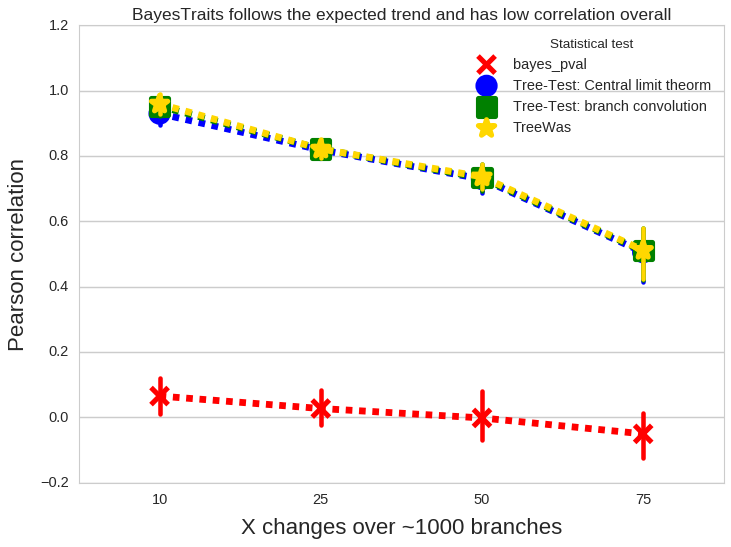

In [377]:
# new ver
# sns.set_style('white')
plt.style.use('seaborn-talk')
plt.close('all')
outpath = '/home/kishonylab/Gal/Workdir/ALISE/figs_data_v2'
n_mutations_list = [10, 25, 50, 75]
pop = 500
ntimes = 10
pval_list = ['pval', 
             'direct_norm_pval',
             'treewas_pval']

plt.figure()
pval_list = ['pval',
             'bayes_pval',
             'direct_norm_pval',
             'direct_conv_pval',
             'treewas_pval']
dat = fig1(n_mutations_list, pop, ntimes, pval_list, outpath, spear=False, weight=False, na_all=True)
dat.columns = ['Change rate: Number of changes over 1000 branches',
               'Statistical test',
               'weighted log absolute distnace']
dat[dat.columns[1]] = dat[dat.columns[1]].replace(
    {'treewas_pval':'TreeWas',
     'direct_norm_pval': 'Tree-Test: Central limit theorm',
     'direct_conv_pval': 'Tree-Test: branch convolution'})
pntplt = sns.pointplot(x=dat.columns[0], y=dat.columns[-1], hue=dat.columns[1], data=dat, linestyles='--', 
              weight=True, markers=['x', "o", "s", "*"], scale = 1.5, palette=['r','b', 'g', 'gold'])
pntplt.set_ylabel('Pearson correlation', rotation=90, fontsize=20, labelpad=10)
pntplt.set_xlabel('X changes over ~1000 branches', rotation=0, fontsize=20, labelpad=10)
plt.title('BayesTraits follows the expected trend and has low correlation overall')
#plt.ylim(0,25)
plt.show()

In [351]:
table_path = os.path.join(outpath, f'mut_25_pop_500_0')
table = pd.read_pickle(table_path)

In [291]:
def BF_to_pval(bs_factor):
    pvals = bs_factor.copy()
    for i,p in zip([0, 10**0, 10**0.5, 10**1, 10**1.5, 10**2], [9e-1, 5e-1, 5e-2, 5e-4, 5e-6, 5e-8]):
        pvals[bs_factor< i] = p
        bs_factor[bs_factor< i] = np.nan
    pvals[bs_factor >= i] = 1e-10
    return pvals

In [221]:
table['bayes_score_corr'] = BF_to_pval(table['bayes_score'].values)

In [352]:
table.dropna()

,pval,score,score_recon,direct_norm_pval,mean_conv_pval,direct_conv_pval,bayes_score,bayes_pval,recon_dist,treewas_pval
133,1.000000,0.0,0,1.000000,1.000000,1.000000,484.958132,4.928102e-106,1,1.000000
1664,1.000000,0.0,0,1.000000,1.000000,1.000000,452.816052,4.701578e-99,10,1.000000
3207,0.397908,1.0,1,0.169802,0.380910,0.369696,478.957220,9.902871e-105,3,0.388389
3302,1.000000,0.0,0,1.000000,1.000000,1.000000,1.328306,5.147093e-01,2,1.000000
3349,0.397908,1.0,1,0.178970,0.380910,0.380348,469.053096,1.400923e-102,4,0.388389
3914,1.000000,0.0,0,1.000000,1.000000,1.000000,9.217024,9.966638e-03,0,1.000000
4203,1.000000,0.0,0,1.000000,1.000000,1.000000,0.978582,6.130609e-01,1,1.000000
4536,1.000000,0.0,0,1.000000,1.000000,1.000000,0.597958,7.415750e-01,0,1.000000
4814,1.000000,0.0,0,1.000000,1.000000,1.000000,0.928232,6.286906e-01,0,1.000000
5408,1.000000,0.0,0,1.000000,1.000000,1.000000,0.219268,8.961621e-01,2,1.000000
